In [1]:
import cv2
import numpy as np
from skimage.feature import greycomatrix, greycoprops
import matplotlib.pyplot as plt

### GLCM
GLCM is a method of examining texture that considers the spatial relationship of pixels
It works by calculating how often pairs of pixel with specific values and in a specified spatial relationship occur in an image, creating a GLCM, and then extracting statistical measures from this matrix.
 Within GLCM, we can also derive some statistics that describe more about the texture:
 - ***Contrast***: Measures the local variations in the gray-level co-occurrence matrix.
 - ***Correlation***: Measures the joint probability occurrence of the specified pixel pairs
 - ***Energy***: Provides the sum of squared elements in the GLCM. Also known as uniformity or the angular second moment.
 - ***Homogeneity***: Measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal.

=> Based on the GLCM properties we have extracted, we can use them for classification or segmentation problem. For example, with 2 different regions in an image, if the dissimilarity of them is large then we can segment these 2 regions

Contrast: [[ 978.65184169 1249.78683386  839.78465909 1353.41082537]]
Dissimilarity: [[21.2705721  24.34307839 19.50656348 25.53678718]]
Homogeneity: [[0.07966667 0.06822032 0.08244357 0.06136623]]
Energy: [[0.01036587 0.00964027 0.01085333 0.00949076]]
Correlation: [[0.74814043 0.67840729 0.78382097 0.65176156]]
ASM: [[1.07451337e-04 9.29347190e-05 1.17794775e-04 9.00745414e-05]]


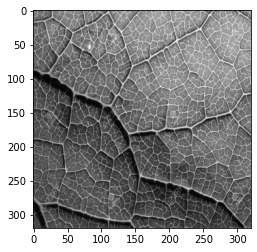

In [4]:
img = cv2.imread('Photos/textures.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (320, 320), interpolation=cv2.INTER_AREA)

PATCH_SIZE = 35
plt.imshow(gray, cmap='gray')

# greycomatrix - Calculate the grey-level co-occurence matrix (GLCM)
# greycoprops - Calculate texture properties of a GLCM

# Param:
# source image
# List of pixel pair distance offsets - here 1 in each direction
# List of pixel pair angles in radians
# GLCM of full image
gray_comatrix = greycomatrix(gray, [1], [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4], levels=256)

# Find the GLCM properties of full image above
contrast = greycoprops(gray_comatrix, 'contrast')
dissimilarity = greycoprops(gray_comatrix, 'dissimilarity')
homogeneity = greycoprops(gray_comatrix, 'homogeneity')
energy = greycoprops(gray_comatrix, 'energy')
correlation = greycoprops(gray_comatrix, 'correlation')
ASM = greycoprops(gray_comatrix, 'ASM')

print("Contrast: {}".format(contrast))
print("Dissimilarity: {}".format(dissimilarity))
print("Homogeneity: {}".format(homogeneity))
print("Energy: {}".format(energy))
print("Correlation: {}".format(correlation))
print("ASM: {}".format(ASM))

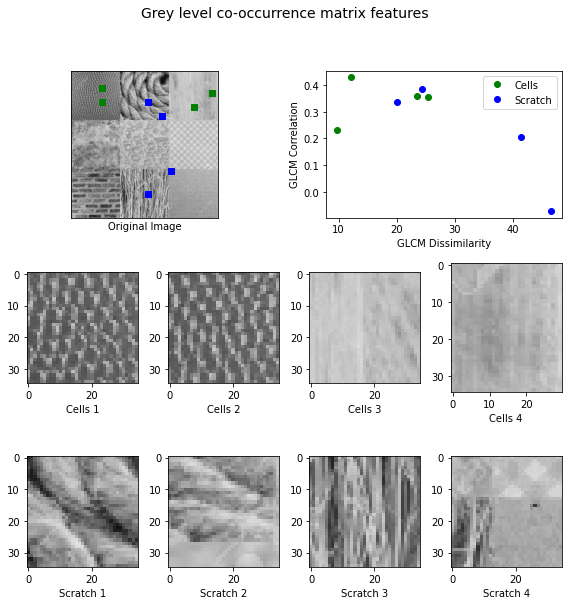

In [20]:
# Select some patches from grassy areas of the image
cell_locations = [(50, 50), (20, 50), (60, 250), (30, 290)]
cell_patches = []
for loc in cell_locations:
    cell_patches.append(gray[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE])

# Select some patches from sky areas of the image
scratch_locations = [(50, 150), (80, 180), (250, 150), (200, 200)]
scratch_patches = []
for loc in scratch_locations:
    scratch_patches.append(gray[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE])

# Compute some GLCM properties of each patch
diss_sim = []
corr = []
homogen = []
ener = []
contr = []

for patch in (cell_patches + scratch_patches):
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    diss_sim.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    corr.append(greycoprops(glcm, 'correlation')[0, 0])
    homogen.append(greycoprops(glcm, 'homogeneity')[0, 0])
    ener.append(greycoprops(glcm, 'energy')[0, 0])
    contr.append(greycoprops(glcm, 'contrast')[0, 0])

fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(gray, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in cell_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in scratch_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(diss_sim[:len(cell_patches)], corr[:len(cell_patches)], 'go',
        label='Cells')
ax.plot(diss_sim[len(cell_patches):], corr[len(cell_patches):], 'bo',
        label='Scratch')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(cell_patches):
    ax = fig.add_subplot(3, len(cell_patches), len(cell_patches) * 1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Cells %d' % (i + 1))

for i, patch in enumerate(scratch_patches):
    ax = fig.add_subplot(3, len(scratch_patches), len(scratch_patches) * 2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Scratch %d' % (i + 1))

# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

### Conclusion:
- As you can see from the figures above, the dissimilarities between 2 groups of cells are small, which means cell 1 and cell 2 have sort of the same texture, similarly with cell 3 and cell 4.
- Similar idea for scratches.

### Local Binary Patterns (LBP)
- LBP is a texture operator that labels the pixels of an image by thresholding the surrounding pixels and expressing them in binary numbers.
- LBPs compute a local representation of texture instead. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels.
- There are ***an original LBP implementation*** and ***an extension to the original LBP implementation***
##### Original LBP:
- Convert the image to grayscale
- For each pixel in the grayscale image, we select a neighborhood of size r surrounding the center pixel
- AN LBP value is then calculated for this center pixel and stored in the output 2D array with the same width and height as the input image.

##### Extended LBP:
- Two parameters were introduced:
    - The number of points p in a circularly symmetric neighborhood to consider (thus removing relying on a square neighborhood).
    - The radius of the circle r, which allows us to account for different scales.

##### Note: LBP uniformity
- An LBP is considered to be uniform if it has at most two 0-1 or 1-0 transitions. (Eg: the pattern 00001000 (2 transitions) and 10000000 (1 transition) are both considered to be uniform patterns since they contain at most two 0-1 and 1-0 transitions while The pattern 01010010 on the other hand is not considered a uniform pattern since it has six 0-1 or 1-0 transitions.)